# Lagged cross-covariance analysis

Resolution: 5-degree, weekly

NOTE: why are some correlation values not in range [-1, 1]?

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to a regular grid and resample to weekly averages within each grid cell
df_sif_weekly = (
    utils.regrid(DS_sif, res=5)
    .groupby(["lon", "lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_weekly = (
    utils.regrid(DS_xco2, res=5)
    .groupby(["lon", "lat"])
    .resample("1W")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_weekly = pd.merge(df_sif_weekly, df_xco2_weekly, on=["lon", "lat", "time"], how="outer")
df_grid_weekly

,lon,lat,time,sif,xco2
0,-177.5,-87.5,2014-11-30,0.013318,NaN
1,-177.5,-87.5,2014-12-07,-0.082351,NaN
2,-177.5,-87.5,2014-12-14,-0.080708,NaN
3,-177.5,-87.5,2014-12-21,NaN,NaN
4,-177.5,-87.5,2014-12-28,NaN,NaN
...,...,...,...,...,...
407796,22.5,52.5,2014-09-14,NaN,395.766266
407797,162.5,-22.5,2020-06-14,NaN,NaN
407798,162.5,-22.5,2020-06-21,NaN,411.494873
407799,167.5,-47.5,2014-09-14,NaN,397.021637


In [6]:
# Convert to dataset and compute statistics
DS_grid_weekly = stats.get_stats(
    df_grid_weekly
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_grid_weekly["xcor_lag1"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=4, tau=30)
DS_grid_weekly["xcor_lag2"] = stats.apply_xcor(DS_grid_weekly.xco2, DS_grid_weekly.sif, lag=8, tau=30)

DS_grid_weekly

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.Dataset>
Dimensions:     (lat: 35, lon: 72, time: 309)
Coordinates:
  * lon         (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat         (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time        (time) datetime64[ns] 2014-09-07 2014-09-14 ... 2020-08-02
Data variables:
    sif         (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2        (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    sif_count   (lon, lat) int64 33 67 0 0 0 0 0 0 0 ... 0 0 54 0 167 156 73 0 0
    xco2_count  (lon, lat) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 66 78 0 0 0
    sif_slope   (lon, lat) float64 -1.947e-05 0.0001208 nan ... nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... 0.05971 nan nan nan
    sif_std     (lon, lat) float64 0.09047 0.1255 nan nan ... 0.1033 nan nan
    xco2_std    (lon, lat) float64 nan nan nan nan nan ... 3.351 nan nan nan
    xcor_lag1   (lon, lat) float64 nan nan nan nan nan ... -0.3543 nan nan nan
    xcor_lag2   (lon, lat) float64 nan nan nan nan nan ... -0.02672 nan nan nan

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))


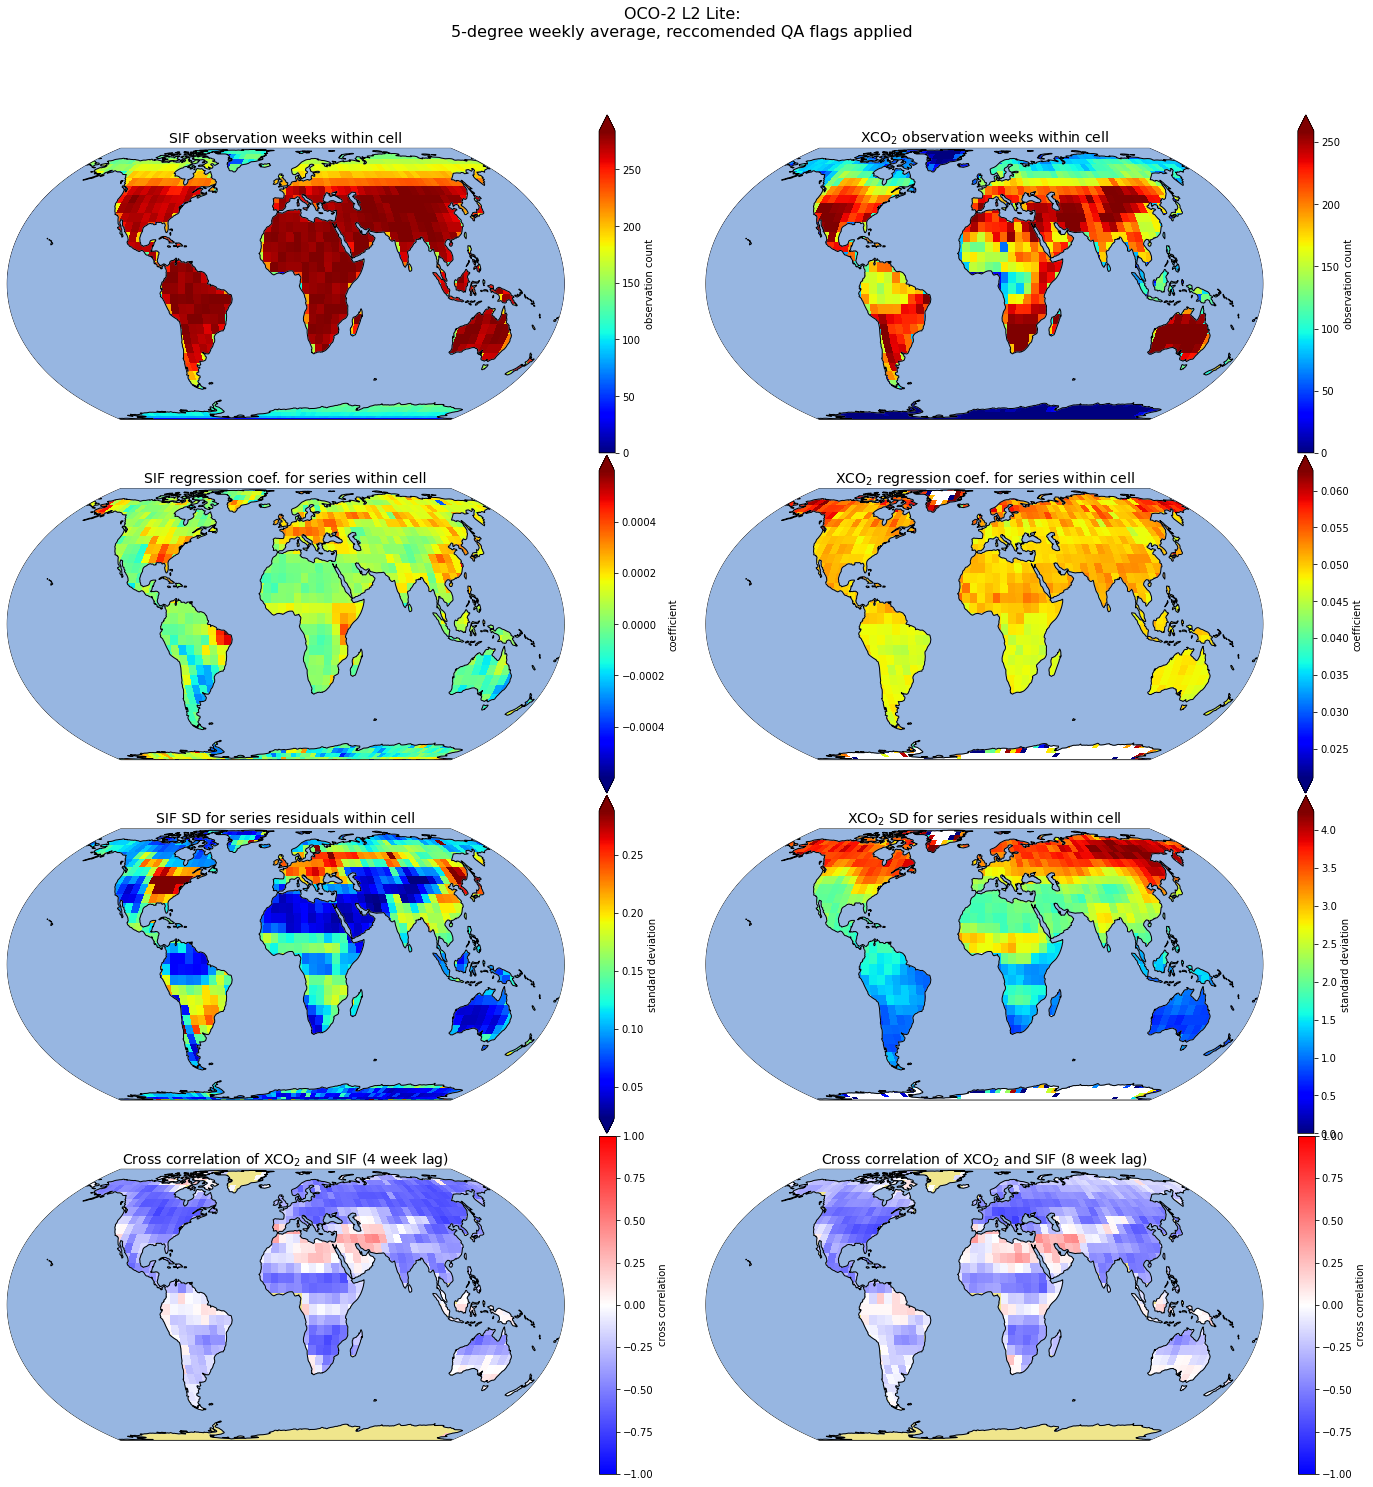

In [7]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "5-degree weekly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_count,
    title="SIF observation weeks within cell",
    ax=ax1,
    cbar_kwargs={"label": "observation count"}
)
plot.plot_da(
    DS_grid_weekly.xco2_count,
    title="XCO$_2$ observation weeks within cell",
    ax=ax2,
    cbar_kwargs={"label": "observation count"}
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_slope,
    title="SIF regression coef. for series within cell",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_weekly.xco2_slope,
    title="XCO$_2$ regression coef. for series within cell",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.sif_std,
    title="SIF SD for series residuals within cell",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_weekly.xco2_std,
    title="XCO$_2$ SD for series residuals within cell",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Define color map with nans set to khaki
cmap = plt.get_cmap("bwr")
cmap.set_bad("khaki")

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_weekly.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (4 week lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_weekly.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (8 week lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/5deg_weekly_panel.png");